In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.DB.Component import Component
from src.DB import init_db

from src.Pipeline import Pipeline
from src.Pipeline.ExceptionPolicy import ExceptionPolicy
from src.Pipeline.ExecutionPolicy import ExecutionPolicy
from src.PipelineSteps import OpenAIE2E, LLMGrader
from src.Pipeline.Grader import Grader
from src.LLM import GPT4oMini
from src.llm_inputs import LLM_INSTRUCTIONS_V2, LLM_QUESTION_V2, GRADING_INSTRUCTIONS_V1, GRADING_PROMPTS
from src.config import GRADING_LLM_TEMPERATURE, GRADING_LLM_TOP_P
from src.config import LATEX_DIR

[LATEXVARS] == Set EXTRACTIONLLMTOPP to 0.2
Saving latex vars to /Users/king/Overleaf/pcbGPT-Benchmark-NeurIPS/latex_vars.tex
[LATEXVARS] == Set EXTRACTIONLLMTEMPERATURE to 0.1
Saving latex vars to /Users/king/Overleaf/pcbGPT-Benchmark-NeurIPS/latex_vars.tex
[LATEXVARS] == Set GRADINGLLMTOPP to 0.2
Saving latex vars to /Users/king/Overleaf/pcbGPT-Benchmark-NeurIPS/latex_vars.tex
[LATEXVARS] == Set GRADINGLLMTEMPERATURE to 0.1
Saving latex vars to /Users/king/Overleaf/pcbGPT-Benchmark-NeurIPS/latex_vars.tex
[LATEXVARS] == Set MAXGENERATIONTOKEN to 4096
Saving latex vars to /Users/king/Overleaf/pcbGPT-Benchmark-NeurIPS/latex_vars.tex
[LATEXVARS] == Set OPENAIEMBEDDINGSMODEL to text-embedding-ada-002
Saving latex vars to /Users/king/Overleaf/pcbGPT-Benchmark-NeurIPS/latex_vars.tex
Database initialized


/Users/king/anaconda3/envs/pcbgpt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
openaiE2E_pipeline = Pipeline(grader=Grader(), pipeline_type="proprietary", save_results=False)
openaiE2E_pipeline.add_step(OpenAIE2E(model="gpt-4o-mini", instructions=LLM_INSTRUCTIONS_V2, question=LLM_QUESTION_V2), execution_policy=ExecutionPolicy.CACHE_ONLY)
openaiE2E_pipeline.add_step(LLMGrader(llm=GPT4oMini(GRADING_LLM_TEMPERATURE, GRADING_LLM_TOP_P), grading_instructions=GRADING_INSTRUCTIONS_V1), execution_policy=ExecutionPolicy.CACHE_ONLY)

best_pipeline = openaiE2E_pipeline

In [4]:

from src.PipelineSteps import FullPageExtractor, TextRag, LLMPinExtractor
from src.LLM import Qwen25_VL_7B_Instruct
from src.config import EXTRACTION_LLM_TEMPERATURE, EXTRACTION_LLM_TOP_P
from src.llm_inputs import RAG_QUERY_V1

pipeline = Pipeline(pipeline_type="vision", grader=Grader(), save_results=False)
pipeline.add_step(FullPageExtractor(), exception_policy=ExceptionPolicy.TRY)
pipeline.add_step(TextRag(RAG_QUERY_V1, num_results=4))
pipeline.add_step([
    LLMPinExtractor(Qwen25_VL_7B_Instruct(EXTRACTION_LLM_TEMPERATURE, EXTRACTION_LLM_TOP_P), LLM_QUESTION_V2, LLM_INSTRUCTIONS_V2, llmOrVLM="vlm")
], exception_policy=ExceptionPolicy.TRY, execution_policy=ExecutionPolicy.CACHE_ONLY)
pipeline.add_step(LLMGrader(GPT4oMini(GRADING_LLM_TEMPERATURE, GRADING_LLM_TOP_P), GRADING_INSTRUCTIONS_V1))

best_pipeline  = pipeline
# grade, output = await pipeline(components, execution_policy=ExecutionPolicy.CACHE_ONLY)
# print("Grade: ", grade)

In [5]:
from functools import lru_cache

async def grouped_pipeline_results(grouped_components):
    grades = {}
    for key, value in grouped_components.items():
        value = [x for x in value if x.pdf_path is not None]
        print(f"Running {key} with {len(value)} components")
        try:
            grade, _ = await best_pipeline(value, execution_policy=ExecutionPolicy.CACHE_ONLY)
            grades[key] = grade[0]
        except Exception as e:
            print(f"Error processing {key}: {e}")
            continue
    return grades

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator

def convert_type(component_type):
    if "sensor" in component_type.lower():
        return "Sensor"
    if "mcu" in component_type.lower():
        return "MCU"
    else:
        raise ValueError(f"Unknown type: {component_type}")

def plot_sorted_by_accuracy(grades, group_by, sort_by="performance", figsize=(6, 6), font_size=18):
    # Extract data
    categories = list(grades.keys())
    accuracies = [round(grades[cat].accuracy, 2) for cat in categories]
    f1_scores = [round(grades[cat].f1_score, 2) for cat in categories]

    # Sorting logic
    if sort_by == "performance":
        sorted_data = sorted(zip(categories, accuracies, f1_scores), key=lambda x: (x[1], x[2]), reverse=False)
    elif sort_by == "x":
        sorted_data = sorted(zip(categories, accuracies, f1_scores), key=lambda x: x[0], reverse=True)
    else:
        raise ValueError(f"Unknown sort key: {sort_by}")

    categories, accuracies, f1_scores = zip(*sorted_data)

    y = np.arange(len(categories))
    height = 0.35

    # Set theme
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=figsize)

    # Draw horizontal bars
    rects1 = ax.barh(y - height/2, accuracies, height, label='Accuracy', edgecolor="black")
    rects2 = ax.barh(y + height/2, f1_scores, height, label='F1 Score', edgecolor="black")
    # Axis settings
    ax.set_xlabel('Score (%)', fontsize=font_size)
    ax.set_yticks(y)
    ax.set_yticklabels(['\n'.join(str(cat).split(',')) for cat in categories], fontsize=font_size)
    ax.tick_params(axis='x', labelsize=font_size-2)
    # ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Add bar labels
    ax.bar_label(rects1, padding=3, fontsize=12)
    ax.bar_label(rects2, padding=3, fontsize=12)

    # Set global font size
    plt.rc('font', size=font_size)

    if group_by == "pins":
        ax.set_ylabel('# Pins', fontsize=font_size)
    if group_by == "manufacturer":
        ax.set_ylabel('Manufacturer', fontsize=font_size)

    # Remove spines
    sns.despine()

    # X-limits
    # min_score = min(min(accuracies), min(f1_scores))
    # ax.set_xlim(min_score - 10, 105)

    # Tight layout and save
    plt.tight_layout()
    plt.legend(size=font_size)
    plt.savefig(f"{LATEX_DIR}/figures/best_performance_{group_by}.pdf", bbox_inches='tight')
    plt.show()

In [7]:
async def plot_grouped_by(group_by, sort_by="performance", custom_reduce_fn=None, min_group_size=1):
    component_manufacturer = await Component.get_all_grouped(group_by, custom_reduce_fn=custom_reduce_fn, only_pdf=True, min_group_size=min_group_size)
    grades = await grouped_pipeline_results(component_manufacturer)
    return grades

In [8]:
manufacturer_unification_map = {
    # Bosch Sensortec
    "bst": "Bosch Sensortec",
    
    # Espressif
    "esp": "Espressif",  # Assuming 'esp' refers to Espressif

    # Infineon
    "inf": "Infineon",
    "Infineon": "Infineon",
    
    # Murata
    "mur": "Murata",
    "Murata": "Murata",
    
    # Nordic Semiconductor
    "nor": "Nordic Semiconductor",
    
    # Renesas Electronics
    "re": "Renesas Electronics",

    # STMicroelectronics
    "stm": "STMicroelectronics",
    "STMicroelectronics": "STMicroelectronics",

    # TDK
    "tdk": "TDK",
    "TDK": "TDK",

    # Texas Instruments
    "ti": "Texas Instruments",
    "Texas Instruments": "Texas Instruments",

    # ROHM
    "ROHM Semiconductor": "ROHM",
    
    # Microchip Technology (fix typo)
    "Michrochip Technology": "Microchip Technology",

    # Rev. 1.10 isn't a manufacturer – discard or label as "Unknown"
    "Rev. 1.10": "Unknown",

    # Default mappings (identity for already unified names)
    "Allegro MicroSystems": "Allegro MicroSystems",
    "Amphenol": "Amphenol",
    "Analog Devices": "Analog Devices",
    "Bosch": "Bosch Sensortec",
    "Diodes Incorporated": "Diodes Incorporated",
    "Endress+Hauser": "Endress+Hauser",
    "Knowles": "Knowles",
    "LEM": "LEM",
    "MEMSIC": "MEMSIC",
    "Microchip Technology": "Microchip Technology",
    "Movella": "Movella",
    "NXP": "NXP",
    "ROHM": "ROHM",
    "Same Sky": "Same Sky",
    "Sensirion": "Sensirion",
    "Silicon Labs": "Silicon Labs",
    "TE Connectivity": "TE Connectivity",
    "Toshiba": "Toshiba",
    "ams OSRAM": "ams OSRAM",
}

grades = await plot_grouped_by("manufacturer", custom_reduce_fn=lambda x: manufacturer_unification_map.get(x, None), min_group_size=5)

Running Other with 31 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 31/31 [00:02<00:00, 14.84step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 31/31 [00:01<00:00, 26.32step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 31/31 [00:01<00:00, 25.39step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 31/31 [00:01<00:00, 23.04step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running TDK with 83 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 83/83 [00:03<00:00, 24.41step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 83/83 [00:03<00:00, 24.86step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 83/83 [00:03<00:00, 25.50step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 83/83 [00:03<00:00, 23.53step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running STMicroelectronics with 135 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 135/135 [00:06<00:00, 21.21step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 135/135 [00:05<00:00, 25.03step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 135/135 [00:05<00:00, 24.70step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 135/135 [00:05<00:00, 23.39step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running Infineon with 130 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 130/130 [00:04<00:00, 27.27step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 130/130 [00:05<00:00, 25.16step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 130/130 [00:05<00:00, 24.78step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 130/130 [00:05<00:00, 23.51step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running Analog Devices with 25 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 25/25 [00:00<00:00, 25.91step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 25/25 [00:00<00:00, 25.10step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 25/25 [00:01<00:00, 22.19step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 25/25 [00:01<00:00, 20.17step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running MEMSIC with 14 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 14/14 [00:00<00:00, 25.98step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 14/14 [00:00<00:00, 24.31step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 14/14 [00:00<00:00, 22.98step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 14/14 [00:00<00:00, 19.61step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running Murata with 18 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 18/18 [00:00<00:00, 28.14step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 18/18 [00:00<00:00, 26.17step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 18/18 [00:00<00:00, 22.52step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 18/18 [00:00<00:00, 23.68step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running Bosch Sensortec with 41 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 41/41 [00:02<00:00, 19.29step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 41/41 [00:01<00:00, 25.30step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 41/41 [00:01<00:00, 23.79step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 41/41 [00:01<00:00, 22.93step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running Texas Instruments with 25 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 25/25 [00:01<00:00, 19.90step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 25/25 [00:01<00:00, 24.66step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 25/25 [00:01<00:00, 24.29step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 25/25 [00:01<00:00, 22.90step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running Allegro MicroSystems with 5 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.45step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 5/5 [00:00<00:00, 24.26step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 5/5 [00:00<00:00, 24.68step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 5/5 [00:00<00:00, 21.86step/s]

Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>


TypeError: Legend.__init__() got an unexpected keyword argument 'font_size'

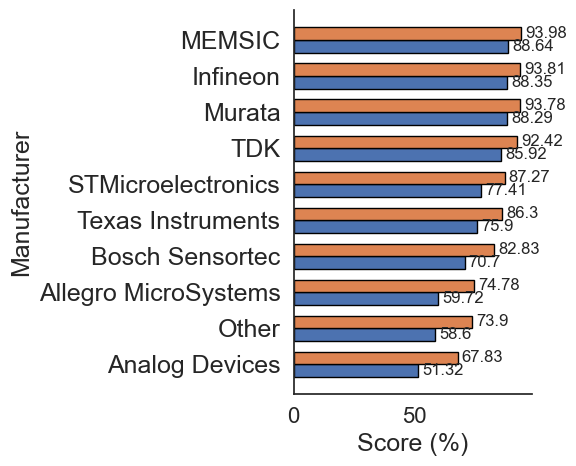

In [22]:
plot_sorted_by_accuracy(grades, "manufacturer", sort_by="performance", figsize=(6, 5))

In [10]:
# await plot_grouped_by("type", custom_reduce_fn=lambda x: ",".join(x.split(", ")[:2]))

In [17]:
def range_reduce_fun(x):
    len_x = len(x)
    bins = [(2, 4), (4, 6), (6, 8), (8, 10), (10, 12), (12, 14), (14, 16)]
    ranges = [f"{start}-{end}" for start, end in bins]
    # find the range for len_x
    for i, (start, end) in enumerate(bins):
        if start <= len_x < end:
            return ranges[i]
    return f"{bins[-1][0]}+"


pin_grades = await plot_grouped_by("pins", custom_reduce_fn=range_reduce_fun)


Running 4-6 with 59 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 59/59 [00:01<00:00, 31.11step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 59/59 [00:02<00:00, 25.42step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 59/59 [00:02<00:00, 24.32step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 59/59 [00:02<00:00, 22.55step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running 8-10 with 80 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 80/80 [00:03<00:00, 22.81step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 80/80 [00:03<00:00, 24.45step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 80/80 [00:03<00:00, 24.40step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 80/80 [00:03<00:00, 23.24step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running 12-14 with 73 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 73/73 [00:03<00:00, 22.62step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 73/73 [00:02<00:00, 25.20step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 73/73 [00:03<00:00, 23.99step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 73/73 [00:03<00:00, 22.39step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running 6-8 with 34 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 34/34 [00:01<00:00, 23.56step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 34/34 [00:01<00:00, 24.88step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 34/34 [00:01<00:00, 26.02step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 34/34 [00:01<00:00, 24.00step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running 14+ with 95 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 95/95 [00:04<00:00, 22.04step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 95/95 [00:03<00:00, 25.09step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 95/95 [00:03<00:00, 24.99step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 95/95 [00:04<00:00, 23.39step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running 14-16 with 52 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 52/52 [00:02<00:00, 17.96step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 52/52 [00:02<00:00, 25.05step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 52/52 [00:02<00:00, 24.69step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 52/52 [00:02<00:00, 22.88step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running 10-12 with 21 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 21/21 [00:00<00:00, 21.57step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 21/21 [00:00<00:00, 23.67step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 21/21 [00:00<00:00, 24.80step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 21/21 [00:00<00:00, 23.36step/s]


Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>
Running 2-4 with 93 components
Running step: FullPageExtractorfull_pages


Processing: 100%|██████████| 93/93 [00:03<00:00, 25.72step/s]


Running step: TextRagquery_v1_4_similarity


Processing: 100%|██████████| 93/93 [00:03<00:00, 24.88step/s]


Running step: LLMPinExtractorQwen/Qwen2.5-VL-7B-Instruct_question_v2_instructions_v2


Processing: 100%|██████████| 93/93 [00:03<00:00, 25.20step/s]


Running step: LLMGradergpt-4o-mini_0.1_0.2_grading_instructions_v1


Processing: 100%|██████████| 93/93 [00:03<00:00, 24.63step/s]

Single_input: <class 'list'>
Single_input_0 <class 'tuple'>
Single_input_0_0 <class 'src.DB.CacheCollection.CacheCollection'>
Single_input_0_1 <class 'src.DB.Component.Component'>


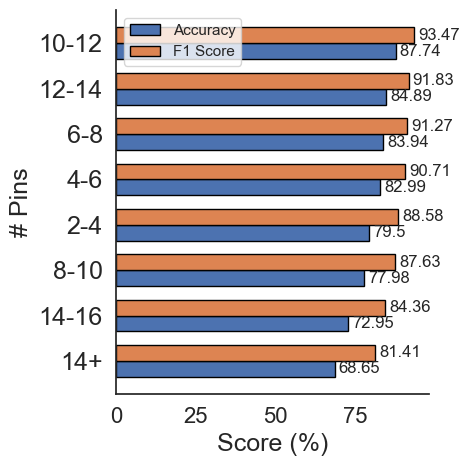

In [20]:
plot_sorted_by_accuracy(pin_grades, "pins", sort_by="performance", figsize=(5, 5))